<a href="https://colab.research.google.com/github/NaingKo9902/-4/blob/master/Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Enable inline plots
%matplotlib inline
# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [0]:
pd.set_option("display.width", 70)

In [0]:
data = pd.read_csv("SolarPrediction.csv")

In [0]:
data["Time"] = (pd
                      .to_datetime(data["UNIXTime"], unit="s", utc=True)
                      .dt.tz_convert("Pacific/Honolulu")).dt.time
data["TimeSunRise"] = (pd
                      .to_datetime(data["TimeSunRise"],
                      infer_datetime_format=True)
                      .dt.time)
data["TimeSunSet"] = (pd
                    .to_datetime(data["TimeSunSet"],
                    infer_datetime_format=True)
                    .dt.time)
data = data.rename({"WindDirection(Degrees)": "WindDirection"},
axis=1)

In [6]:
data.dtypes

UNIXTime           int64
Data              object
Time              object
Radiation        float64
Temperature        int64
Pressure         float64
Humidity           int64
WindDirection    float64
Speed            float64
TimeSunRise       object
TimeSunSet        object
dtype: object

In [7]:
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection,Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [0]:
def time_to_second(t):
      return ((datetime.combine(datetime.min, t) - datetime.min)
          .total_seconds())

In [9]:
df = data.copy()
timeInSeconds = df["Time"].map(time_to_second)
sunrise = df["TimeSunRise"].map(time_to_second)
sunset = df["TimeSunSet"].map(time_to_second)
df["DayPart"] = (timeInSeconds - sunrise) / (sunset - sunrise)
df = df.drop(["UNIXTime", "Data", "Time",
"TimeSunRise", "TimeSunSet"], axis=1)
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection,Speed,DayPart
0,1.21,48,30.46,59,177.39,5.62,1.475602
1,1.21,48,30.46,58,176.78,3.37,1.468588
2,1.23,48,30.46,57,158.75,3.37,1.461713
3,1.21,48,30.46,60,137.71,3.37,1.454653
4,1.17,48,30.46,62,104.95,5.62,1.447778


In [10]:
df.dtypes

Radiation        float64
Temperature        int64
Pressure         float64
Humidity           int64
WindDirection    float64
Speed            float64
DayPart          float64
dtype: object

In [11]:
df.shape

(32686, 7)

In [12]:
df.describe()

,Radiation,Temperature,Pressure,Humidity,WindDirection,Speed,DayPart
count,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869,0.482959
std,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474,0.602432
min,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000,-0.634602
25%,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000,-0.040139
50%,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000,0.484332
75%,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000,1.006038
max,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000,1.566061


In [13]:
df.isnull().sum()

Radiation        0
Temperature      0
Pressure         0
Humidity         0
WindDirection    0
Speed            0
DayPart          0
dtype: int64

In [0]:
X = df.drop("Radiation", axis=1)
y = df["Radiation"]

In [16]:
print(X.head(), "\n")
print(y.head())

   Temperature  Pressure  Humidity  WindDirection  Speed   DayPart
0           48     30.46        59         177.39   5.62  1.475602
1           48     30.46        58         176.78   3.37  1.468588
2           48     30.46        57         158.75   3.37  1.461713
3           48     30.46        60         137.71   3.37  1.454653
4           48     30.46        62         104.95   5.62  1.447778 

0    1.21
1    1.21
2    1.23
3    1.21
4    1.17
Name: Radiation, dtype: float64


In [17]:
print(X.shape)
print(y.shape)

(32686, 6)
(32686,)


In [18]:
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,Temperature,Pressure,Humidity,WindDirection,Speed,DayPart
count,3.268600e+04,3.268600e+04,3.268600e+04,3.268600e+04,3.268600e+04,3.268600e+04
mean,8.257741e-15,-8.589409e-14,9.563964e-16,-6.186353e-16,-2.072571e-14,-2.846377e-17
std,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00
min,-2.758117e+00,-4.259540e+00,-2.578560e+00,-1.724255e+00,-1.788859e+00,-1.855112e+00
25%,-8.229646e-01,-4.184734e-01,-7.316829e-01,-7.366250e-01,-8.233591e-01,-8.683240e-01
50%,-1.779139e-01,1.302504e-01,3.841386e-01,5.062367e-02,-1.787376e-01,2.279483e-03
75%,6.283995e-01,6.789742e-01,8.458578e-01,4.307058e-01,4.658840e-01,8.682924e-01
max,3.208603e+00,2.508053e+00,1.076717e+00,2.602741e+00,9.814329e+00,1.797910e+00


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.25, random_state=346705925)

In [20]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(24514, 6)
(8172, 6)
(24514,)
(8172,)


In [0]:
def test_model(model):
  print("mean_absolute_error:",
      mean_absolute_error(y_test, model.predict(X_test)))
  print("median_absolute_error:",
      median_absolute_error(y_test, model.predict(X_test)))
  print("r2_score:",
      r2_score(y_test, model.predict(X_test)))

In [22]:
ran_100 = RandomForestRegressor(n_estimators=100)
ran_100.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [23]:
test_model(ran_100)

mean_absolute_error: 37.971800159079784
median_absolute_error: 0.6131500000000007
r2_score: 0.9160165078211935


In [24]:
gr_100 = GradientBoostingRegressor(n_estimators=100)
gr_100.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [25]:
test_model(gr_100)

mean_absolute_error: 58.07682041283236
median_absolute_error: 14.741421993961112
r2_score: 0.8729966247836403


In [26]:
param_range = np.arange(10, 201, 10)
tuned_parameters = [{'n_estimators': param_range}]
tuned_parameters

[{'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
         140, 150, 160, 170, 180, 190, 200])}]

In [27]:
gs = GridSearchCV(RandomForestRegressor(), tuned_parameters,
cv=ShuffleSplit(n_splits=10), scoring="r2",
return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=110, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

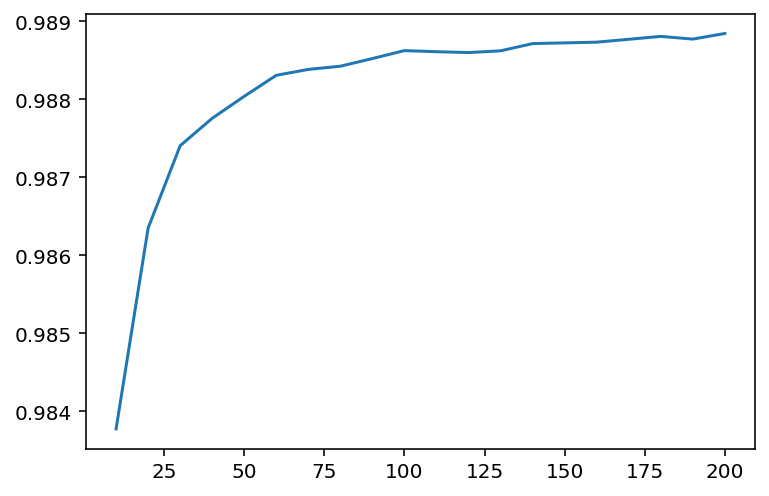

In [28]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

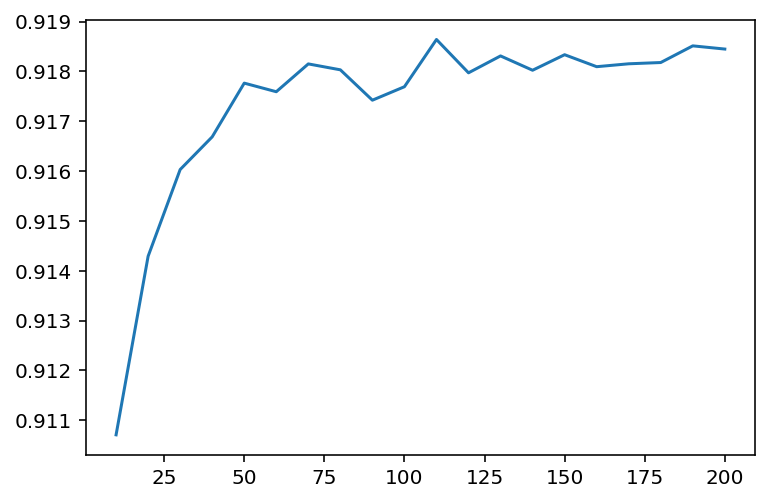

In [29]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

In [30]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 37.79931936101099
median_absolute_error: 0.5981363636363626
r2_score: 0.9165680682079369


In [31]:
tuned_parameters

[{'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
         140, 150, 160, 170, 180, 190, 200])}]

In [32]:
gs = GridSearchCV(GradientBoostingRegressor(), tuned_parameters,
cv=ShuffleSplit(n_splits=10), scoring="r2",
return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

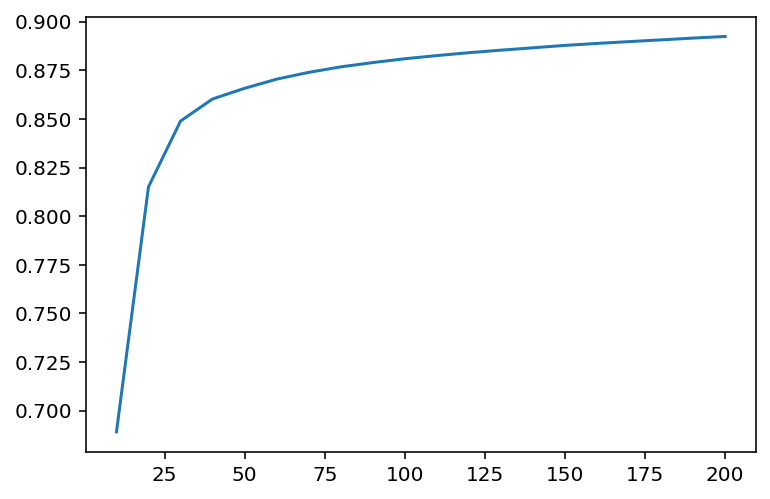

In [33]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

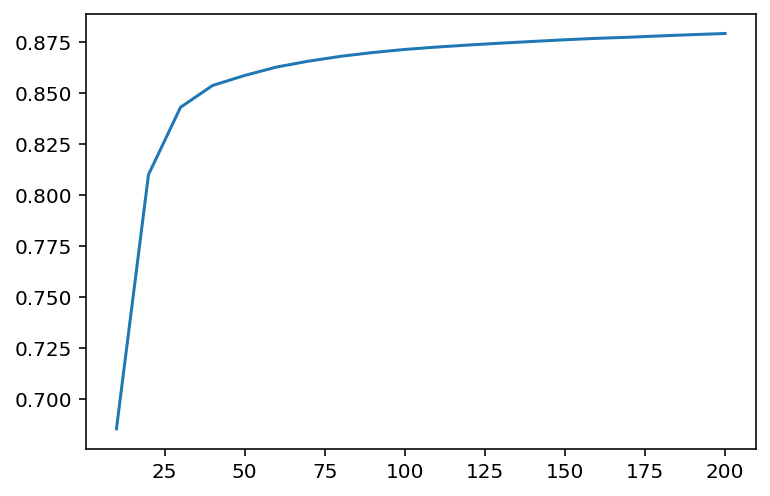

In [34]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

In [35]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 55.85070842093091
median_absolute_error: 14.572172035170833
r2_score: 0.8810191887601053
